**Part 4: Linear regression with weak correlations removed**

In the part 0 we did some basic prepossing. We saw that there were 34 numerical features, and 45 categorical, for a total of 79 features. In part 1 we performed a linear regression using only the 34 numerical features. In part 2 we transformed 22 categorical features into numerical features via transformations, and performed a linear regression on the enlarged set of numerical features, 56 in total. In part 3 we removed those categorical values which we believe contain little information, incorporated the remaining categorical features using one-hot encoding, and performed a linear regression on the result. In this part we attempt to improve our result by investigating those features weakly correlated with the sale price.

Our motivation is to identify features which contribute little to the sale price, and remove them in both train and test, thereby (hopefully) reducing noise. Noise is essentially the random variations present in almost all real-world data. The random nature of noise makes it impossible to predict, and so it must be removed when identified. Features which are weakly correlated with the sale price are likely to contain noise, and so our sale price predictions are likely to improve if these are removed.

Mathematically, we wish to indentify features whose train columns are (largely) linear independent of the train SalePrice columns. Of course, correlation does not necessarily imply dependence, and weak correlation does not necessarily imply linear independence. Nevertheless, weak correlation _may_ indicate that linear independence exists, and so it worth investigating.

We begin by reproducing steps 1-3 of part 3, except for the log transformation of the train SalePrice, as it makes sense to wait until the correlation investigation is complete before doing this transformation. 

**Step 1: Reproduce steps 1-3 of part 3**

In [1]:
import pandas as pd
import numpy as np

# Import train and test data, save train SalePrice and test Id separately, remove train SalePrice and train and test Id
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
train.drop(['Id'], axis=1, inplace=True)
submission = test[['Id']]
test.drop(['Id'], axis=1, inplace=True)
train_sale_price = train[['SalePrice']]
train.drop(['SalePrice'], axis=1, inplace=True)

# Split features/columns into numerical and categorical lists
numeric_features_columns = list(train.select_dtypes(include=[np.number]).columns)
categorical_features_list_to_remove_from_numerical = ['MSSubClass', 'MoSold']
numeric_features_columns = list(set(numeric_features_columns) - set(categorical_features_list_to_remove_from_numerical))
train['MSSubClass'] = train['MSSubClass'].apply(str)
test['MSSubClass'] = test['MSSubClass'].apply(str)
train['MoSold'] = train['MoSold'].apply(str)
test['MoSold'] = test['MoSold'].apply(str)
categorical_features_columns = list(set(train.columns) - set(numeric_features_columns))

# Fill in the missing data
latest_year_house_sold = train['YrSold'].max()
train['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True)
test['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True)
train_numeric_features_with_missing_values = [feature for feature in numeric_features_columns if train[feature].isnull().sum() > 0]
test_numeric_features_with_missing_values = [feature for feature in numeric_features_columns if test[feature].isnull().sum() > 0]
train_categoric_features_with_missing_values = [feature for feature in categorical_features_columns if train[feature].isnull().sum() > 0]
test_categoric_features_with_missing_values = [feature for feature in categorical_features_columns if test[feature].isnull().sum() > 0]

for feature in train_numeric_features_with_missing_values:
    train[feature].fillna(0, inplace = True)

for feature in test_numeric_features_with_missing_values:
    test[feature].fillna(0, inplace = True)

categoric_features_with_NA = [
    'Alley',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'Fence',
    'FireplaceQu',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'GarageType',
    'MiscFeature',
    'PoolQC'
]
for feature in train_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA:
        train[feature].fillna('NA', inplace = True)
    else:
        train[feature].fillna(train[feature].value_counts().idxmax(), inplace = True)
        
for feature in test_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA:
        test[feature].fillna('NA', inplace = True)
    else:
        test[feature].fillna(test[feature].value_counts().idxmax(), inplace = True)

# Convert year features to age features
year_features = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
train['AgeOfHouse'] = train['YrSold'] - train['YearBuilt']
train['AgeOfRemodAdd'] = train['YrSold'] - train['YearRemodAdd']
train['AgeOfGarage'] = train['YrSold'] - train['GarageYrBlt']
train['AgeOfSale'] = latest_year_house_sold - train['YrSold']
test['AgeOfHouse'] = test['YrSold'] - test['YearBuilt']
test['AgeOfRemodAdd'] = test['YrSold'] - test['YearRemodAdd']
test['AgeOfGarage'] = test['YrSold'] - test['GarageYrBlt']
test['AgeOfSale'] = latest_year_house_sold - test['YrSold']
age_features = ['AgeOfHouse', 'AgeOfRemodAdd', 'AgeOfGarage', 'AgeOfSale']
train.drop(year_features, axis=1, inplace=True)
test.drop(year_features, axis=1, inplace=True)
numeric_features_columns = list(set(numeric_features_columns) - set(year_features))
numeric_features_columns = list(set(numeric_features_columns).union(set(age_features)))

# Define categorical features to transform to categorical, and the chosen numerical transformations
categorical_features_to_convert_to_numerical = [
    'Alley',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'CentralAir',
    'ExterCond',
    'ExterQual',
    'Fence',
    'FireplaceQu',
    'Functional',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'HeatingQC',
    'KitchenQual',
    'LandSlope',
    'PavedDrive',
    'PoolQC',
    'Street',
    'Utilities'
]

def numerical_transformations(feature, x):
    if feature in ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'PoolQC']:
        if x == 'Ex':
            return 4
        elif x == 'Gd':
            return 3
        elif x == 'TA':
            return 2
        elif x == 'Fa':
            return 1
        else:
            return 0

    if feature in ['BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond']: 
        if x == 'Ex':
            return 5
        elif x == 'Gd':
            return 4
        elif x == 'TA':
            return 3
        elif x == 'Fa':
            return 2
        elif x == 'Po':
            return 1
        else:
            return 0

    if feature in ['BsmtFinType1', 'BsmtFinType2']:
        if x == 'GLQ':
            return 6
        elif x == 'ALQ':
            return 5
        elif x == 'BLQ':
            return 4
        elif x == 'Rec':
            return 3
        elif x == 'LwQ':
            return 2
        elif x == 'Unf':
            return 1
        else:
            return 0

    if feature == 'BsmtExposure':
        if x == 'Gd':
            return 4
        elif x == 'Av':
            return 3
        elif x == 'Mn':
            return 2
        elif x == 'No':
            return 1
        else:
            return 0

    if feature == 'Functional':
        if x == 'Typ':
            return 7
        elif x == 'Min1':
            return 6
        elif x == 'Min2':
            return 5
        elif x == 'Mod':
            return 4
        elif x == 'Maj1':
            return 3
        elif x == 'Maj2':
            return 2
        elif x == 'Sev':
            return 1
        else:
            return 0

    if feature == 'GarageFinish':
        if x == 'Fin':
            return 3
        elif x == 'RFn':
            return 2
        elif x == 'Unf':
            return 1
        else:
            return 0

    if feature == 'Fence':
        if x == 'GdPrv':
            return 4
        elif x == 'MnPrv':
            return 3
        elif x == 'GdWo':
            return 2
        elif x == 'MnWw':
            return 1
        else:
            return 0

    if feature == 'BsmtQual':
        if x == 'Ex':
            return 105
        elif x == 'Gd':
            return 95
        elif x == 'TA':
            return 85
        elif x == 'Fa':
            return 75
        elif x == 'Po':
            return 65
        else:
            return 0
        
    if feature == 'CentralAir':
        if x == 'Y':
            return 1
        else:
            return 0
        
    if feature == 'Street':
        if x == 'Pave':
            return 1
        else:
            return 0

    if feature == 'Alley':
        if x == 'Grvl' or x == 'Pave':
            return 1
        else:
            return 0

    if feature == 'LandSlope':
        if x == 'Gtl':
            return 1
        else:
            return 0
        
    if feature == 'PavedDrive':
        if x == 'Y' or x == 'P':
            return 1
        else:
            return 0
    
    if feature == 'Utilities':
        if x == 'AllPub':
            return 1
        else:
            return 0

# Transform the chosen categorical features using the numerical chosen transformations
for feature in categorical_features_to_convert_to_numerical:
    train[feature] = train[feature].apply(lambda x: numerical_transformations(feature, x))
    test[feature] = test[feature].apply(lambda x: numerical_transformations(feature, x))
    categorical_features_columns.remove(feature)
    numeric_features_columns.append(feature)
    
# Remove categorical features with too few unique entries
train_categorical_features_with_few_unique_entries = [feature for feature in categorical_features_columns if train[feature].value_counts()[0]/len(train.index) > 0.9]
test_categorical_features_with_few_unique_entries = [feature for feature in categorical_features_columns if test[feature].value_counts()[0]/len(test.index) > 0.9]
categorical_features_list_with_too_few_unique_entries = list(set(train_categorical_features_with_few_unique_entries).union(set(test_categorical_features_with_few_unique_entries)))
categorical_features_columns = list(set(categorical_features_columns) - set(categorical_features_list_with_too_few_unique_entries))
train.drop(categorical_features_list_with_too_few_unique_entries, axis=1, inplace=True)
test.drop(categorical_features_list_with_too_few_unique_entries, axis=1, inplace=True)

# Replace categorical features with one-hot encoded dummy numerical features
def train_dummy_features_constructor(feature):
    return pd.get_dummies(train[feature]).rename(columns=lambda x: (feature + '_' + str(x)))

def test_dummy_features_constructor(feature):
    return pd.get_dummies(test[feature]).rename(columns=lambda x: (feature + '_' + str(x)))

for feature in categorical_features_columns:    
    train = pd.concat([train,train_dummy_features_constructor(feature)], axis=1)
    test = pd.concat([test,test_dummy_features_constructor(feature)], axis=1)
    train.drop([feature], axis=1, inplace=True)
    test.drop([feature], axis=1, inplace=True)
    
columns_in_train_but_not_test = list(set(train.columns) - set(test.columns))
columns_in_test_but_not_train = list(set(test.columns) - set(train.columns))
train.drop(columns_in_train_but_not_test, axis=1, inplace=True)
test.drop(columns_in_test_but_not_train, axis=1, inplace=True)

print(len(numeric_features_columns))
print(train.shape)
print(test.shape)

56
(1460, 213)
(1459, 213)


As a reminder, numeric_features_columns represents the extended set of 56 numerical features: The original 34 numerical features (part 0), and the 22 categorical features that we converted into numerical features via transformations (part 2). The other 157 = 213-56 numerical features were constructed from the categorical features via one-hot encoding (part 3).

**Step 2: The train correlation matrix, and removing weak correlations**

We now add the train SalePrice back to the train matrix, and investigate those train features with low correlations with the SalePrice train correlation matrix. Correlations take values between -1 and +1, and values close to 0 indicate low correlation. Specifically, we identify train columns whose correlation with the train SalePrice column lies between -0.05 and +0.05. 

In [2]:
features = list(train.columns) # All features in train and test
train_correlations = pd.concat([train, train_sale_price['SalePrice']], axis=1).corr() # Dataframe with the correlations of all columns of train, including SalePrice

features_with_low_correlation_to_sale_price = [feature for feature in features if train_correlations[feature]['SalePrice'] < .05 and train_correlations[feature]['SalePrice'] > -.05] # All train featutes for which the correlation with train SalePrice is between -0.1 and +0.1.

print(len(features_with_low_correlation_to_sale_price)) # Length of the list
print(features_with_low_correlation_to_sale_price) # Print the list

78
['Street', 'Utilities', 'ExterCond', 'BsmtFinType2', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', '3SsnPorch', 'MiscVal', 'AgeOfSale', 'LotShape_IR3', 'BldgType_TwnhsE', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'MasVnrType_BrkCmn', 'RoofStyle_Flat', 'RoofStyle_Gambrel', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_Wd Shng', 'LandContour_Low', 'LandContour_Lvl', 'MoSold_1', 'MoSold_10', 'MoSold_11', 'MoSold_12', 'MoSold_2', 'MoSold_3', 'MoSold_4', 'MoSold_5', 'MoSold_6', 'MoSold_7', 'MoSold_8', 'MoSold_9', 'Exterior1st_AsphShn', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_Plywood', 'Exterior1st_Stucco', 'GarageType_2Types', 'GarageType_Basment', 'LotConfig_Corner', 'LotConfig_FR2', 'LotConfig_FR3', 'Foundation_Stone', 'Foundation_Wood', 'Neighborhood_Blmngtn'

78 out of 213 train features are weakly correlated with the train SalePrice.

Note, as stated in the beginning (above), weak correlation does not necessarily imply linear independence. Because of this we should attempt to convince ourselves in some way that each of the above features is indeed (largely) linearly independent of SalePrice. For the sake of simplicity however, we omit this step, and simply
remove all the weakly correlated features from both train and test.

In [3]:
numeric_features_columns = list(set(numeric_features_columns) - set(features_with_low_correlation_to_sale_price)) # The extended numeric features which remain after removing weakly correlated features
train.drop(features_with_low_correlation_to_sale_price, axis=1, inplace=True)
test.drop(features_with_low_correlation_to_sale_price, axis=1, inplace=True)

print(len(numeric_features_columns))
print(train.shape)
print(test.shape)

46
(1460, 135)
(1459, 135)


Of the 56 features in the extended numerical set, 46 remain after removing the weak correlations. Of the 213 total features, 135 remain. Next perform the log transformation of the train SalePrice as before.

In [4]:
train_sale_price['SalePrice'] = train_sale_price['SalePrice'].apply(np.log) # Log transform train SalePrice

**Step 3: Linear regression**

We now perform linear regression with the above reduced set of features. First the train-test split.

0.1357891634198178


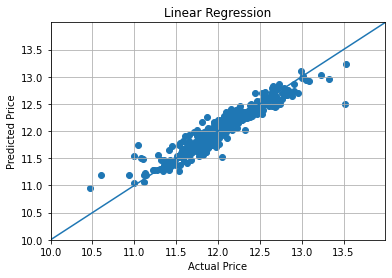

In [5]:
X = train.copy()
Y = train_sale_price.copy()

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=.33)
actual_log_prices = y_test

lr = linear_model.LinearRegression()
model = lr.fit(x_train, y_train)
predicted_log_prices = model.predict(x_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

print(np.sqrt(mean_squared_error(predicted_log_prices, actual_log_prices)))

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(10, 14, .5))
ax.set_yticks(np.arange(10, 14, .5))
plt.xlim(10,  14)
plt.ylim(10, 14)
plt.plot([10,14], [10,14])
plt.grid()
plt.scatter(actual_log_prices, predicted_log_prices)
plt.ylabel('Predicted Price')
plt.xlabel('Actual Price')
plt.title('Linear Regression')
plt.show() 

Next the linear regression using the whole of X and Y.

In [6]:
model = lr.fit(X, Y)
X_test = test.copy()
predicted_log_prices = model.predict(X_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

submission['SalePrice'] = predicted_log_prices['SalePrice'].apply(np.exp)
submission.to_csv('submission.csv',index=False)

Submitting to kaggle gives an **RMSE score of 0.13864**, a slight improvement over part 3.

**Step 4: Linear regression with only the extended numeric set, no one-hot encoding**

Recall that the extended set of numerical set contained 56 features, and that 46 numerical features remained after we removed the weak correlations above. Here we perform the linear regression using only these 46 numerical features, and so we ignore the one-hot encoded categorical features.

First the train-test split with this reduced set of features.

0.1521269172107258


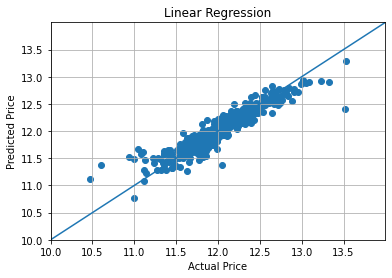

In [7]:
X = X[numeric_features_columns] # We restrict to the numeric features
x_train = x_train[numeric_features_columns] # We restrict to the numeric features
x_test = x_test[numeric_features_columns] # We restrict to the numeric features
# Y and y_train and y_test are are unchanged from above

lr = linear_model.LinearRegression()
model = lr.fit(x_train, y_train)
predicted_log_prices = model.predict(x_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

print(np.sqrt(mean_squared_error(predicted_log_prices, actual_log_prices)))

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(10, 14, .5))
ax.set_yticks(np.arange(10, 14, .5))
plt.xlim(10,  14)
plt.ylim(10, 14)
plt.plot([10,14], [10,14])
plt.grid()
plt.scatter(actual_log_prices, predicted_log_prices)
plt.ylabel('Predicted Price')
plt.xlabel('Actual Price')
plt.title('Linear Regression')
plt.show() 

Next the linear regression using the whole of X and Y, using only the 46 numerical features.

In [8]:
model = lr.fit(X, Y)
X_test = X_test[numeric_features_columns] # We restrict to the numeric features
predicted_log_prices = model.predict(X_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

submission['SalePrice'] = predicted_log_prices['SalePrice'].apply(np.exp)
submission.to_csv('submission.csv',index=False)

Submitting to kaggle gives an **RMSE score of 0.14517**. This is not a significant improvement over part 2.

**Step 5: Linear regression with a smaller set of weak correlations removed.**

Here, for comparison, we only remove correlations between -.1 and +0.1. Previously we removed correlations between -0.05 and +0.05. We begin with the one-hot encoded features included, reproducing steps 1,2,3 above.

In [9]:
import pandas as pd
import numpy as np

# Import train and test data, save train SalePrice and test Id separately, remove train SalePrice and train and test Id
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
train.drop(['Id'], axis=1, inplace=True)
submission = test[['Id']]
test.drop(['Id'], axis=1, inplace=True)
train_sale_price = train[['SalePrice']]
train.drop(['SalePrice'], axis=1, inplace=True)

# Split features/columns into numerical and categorical lists
numeric_features_columns = list(train.select_dtypes(include=[np.number]).columns)
categorical_features_list_to_remove_from_numerical = ['MSSubClass', 'MoSold']
numeric_features_columns = list(set(numeric_features_columns) - set(categorical_features_list_to_remove_from_numerical))
train['MSSubClass'] = train['MSSubClass'].apply(str)
test['MSSubClass'] = test['MSSubClass'].apply(str)
train['MoSold'] = train['MoSold'].apply(str)
test['MoSold'] = test['MoSold'].apply(str)
categorical_features_columns = list(set(train.columns) - set(numeric_features_columns))

# Fill in the missing data
latest_year_house_sold = train['YrSold'].max()
train['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True)
test['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True)
train_numeric_features_with_missing_values = [feature for feature in numeric_features_columns if train[feature].isnull().sum() > 0]
test_numeric_features_with_missing_values = [feature for feature in numeric_features_columns if test[feature].isnull().sum() > 0]
train_categoric_features_with_missing_values = [feature for feature in categorical_features_columns if train[feature].isnull().sum() > 0]
test_categoric_features_with_missing_values = [feature for feature in categorical_features_columns if test[feature].isnull().sum() > 0]

for feature in train_numeric_features_with_missing_values:
    train[feature].fillna(0, inplace = True)

for feature in test_numeric_features_with_missing_values:
    test[feature].fillna(0, inplace = True)

categoric_features_with_NA = [
    'Alley',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'Fence',
    'FireplaceQu',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'GarageType',
    'MiscFeature',
    'PoolQC'
]
for feature in train_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA:
        train[feature].fillna('NA', inplace = True)
    else:
        train[feature].fillna(train[feature].value_counts().idxmax(), inplace = True)
        
for feature in test_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA:
        test[feature].fillna('NA', inplace = True)
    else:
        test[feature].fillna(test[feature].value_counts().idxmax(), inplace = True)

# Convert year features to age features
year_features = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
train['AgeOfHouse'] = train['YrSold'] - train['YearBuilt']
train['AgeOfRemodAdd'] = train['YrSold'] - train['YearRemodAdd']
train['AgeOfGarage'] = train['YrSold'] - train['GarageYrBlt']
train['AgeOfSale'] = latest_year_house_sold - train['YrSold']
test['AgeOfHouse'] = test['YrSold'] - test['YearBuilt']
test['AgeOfRemodAdd'] = test['YrSold'] - test['YearRemodAdd']
test['AgeOfGarage'] = test['YrSold'] - test['GarageYrBlt']
test['AgeOfSale'] = latest_year_house_sold - test['YrSold']
age_features = ['AgeOfHouse', 'AgeOfRemodAdd', 'AgeOfGarage', 'AgeOfSale']
train.drop(year_features, axis=1, inplace=True)
test.drop(year_features, axis=1, inplace=True)
numeric_features_columns = list(set(numeric_features_columns) - set(year_features))
numeric_features_columns = list(set(numeric_features_columns).union(set(age_features)))

# Define categorical features to transform to categorical, and the chosen numerical transformations
categorical_features_to_convert_to_numerical = [
    'Alley',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'CentralAir',
    'ExterCond',
    'ExterQual',
    'Fence',
    'FireplaceQu',
    'Functional',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'HeatingQC',
    'KitchenQual',
    'LandSlope',
    'PavedDrive',
    'PoolQC',
    'Street',
    'Utilities'
]

def numerical_transformations(feature, x):
    if feature in ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'PoolQC']:
        if x == 'Ex':
            return 4
        elif x == 'Gd':
            return 3
        elif x == 'TA':
            return 2
        elif x == 'Fa':
            return 1
        else:
            return 0

    if feature in ['BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond']: 
        if x == 'Ex':
            return 5
        elif x == 'Gd':
            return 4
        elif x == 'TA':
            return 3
        elif x == 'Fa':
            return 2
        elif x == 'Po':
            return 1
        else:
            return 0

    if feature in ['BsmtFinType1', 'BsmtFinType2']:
        if x == 'GLQ':
            return 6
        elif x == 'ALQ':
            return 5
        elif x == 'BLQ':
            return 4
        elif x == 'Rec':
            return 3
        elif x == 'LwQ':
            return 2
        elif x == 'Unf':
            return 1
        else:
            return 0

    if feature == 'BsmtExposure':
        if x == 'Gd':
            return 4
        elif x == 'Av':
            return 3
        elif x == 'Mn':
            return 2
        elif x == 'No':
            return 1
        else:
            return 0

    if feature == 'Functional':
        if x == 'Typ':
            return 7
        elif x == 'Min1':
            return 6
        elif x == 'Min2':
            return 5
        elif x == 'Mod':
            return 4
        elif x == 'Maj1':
            return 3
        elif x == 'Maj2':
            return 2
        elif x == 'Sev':
            return 1
        else:
            return 0

    if feature == 'GarageFinish':
        if x == 'Fin':
            return 3
        elif x == 'RFn':
            return 2
        elif x == 'Unf':
            return 1
        else:
            return 0

    if feature == 'Fence':
        if x == 'GdPrv':
            return 4
        elif x == 'MnPrv':
            return 3
        elif x == 'GdWo':
            return 2
        elif x == 'MnWw':
            return 1
        else:
            return 0

    if feature == 'BsmtQual':
        if x == 'Ex':
            return 105
        elif x == 'Gd':
            return 95
        elif x == 'TA':
            return 85
        elif x == 'Fa':
            return 75
        elif x == 'Po':
            return 65
        else:
            return 0
        
    if feature == 'CentralAir':
        if x == 'Y':
            return 1
        else:
            return 0
        
    if feature == 'Street':
        if x == 'Pave':
            return 1
        else:
            return 0

    if feature == 'Alley':
        if x == 'Grvl' or x == 'Pave':
            return 1
        else:
            return 0

    if feature == 'LandSlope':
        if x == 'Gtl':
            return 1
        else:
            return 0
        
    if feature == 'PavedDrive':
        if x == 'Y' or x == 'P':
            return 1
        else:
            return 0
    
    if feature == 'Utilities':
        if x == 'AllPub':
            return 1
        else:
            return 0

# Transform the chosen categorical features using the numerical chosen transformations
for feature in categorical_features_to_convert_to_numerical:
    train[feature] = train[feature].apply(lambda x: numerical_transformations(feature, x))
    test[feature] = test[feature].apply(lambda x: numerical_transformations(feature, x))
    categorical_features_columns.remove(feature)
    numeric_features_columns.append(feature)
    
# Remove categorical features with too few unique entries
train_categorical_features_with_few_unique_entries = [feature for feature in categorical_features_columns if train[feature].value_counts()[0]/len(train.index) > 0.9]
test_categorical_features_with_few_unique_entries = [feature for feature in categorical_features_columns if test[feature].value_counts()[0]/len(test.index) > 0.9]
categorical_features_list_with_too_few_unique_entries = list(set(train_categorical_features_with_few_unique_entries).union(set(test_categorical_features_with_few_unique_entries)))
categorical_features_columns = list(set(categorical_features_columns) - set(categorical_features_list_with_too_few_unique_entries))
train.drop(categorical_features_list_with_too_few_unique_entries, axis=1, inplace=True)
test.drop(categorical_features_list_with_too_few_unique_entries, axis=1, inplace=True)

# Replace categorical features with one-hot encoded dummy numerical features
def train_dummy_features_constructor(feature):
    return pd.get_dummies(train[feature]).rename(columns=lambda x: (feature + '_' + str(x)))

def test_dummy_features_constructor(feature):
    return pd.get_dummies(test[feature]).rename(columns=lambda x: (feature + '_' + str(x)))

for feature in categorical_features_columns:    
    train = pd.concat([train,train_dummy_features_constructor(feature)], axis=1)
    test = pd.concat([test,test_dummy_features_constructor(feature)], axis=1)
    train.drop([feature], axis=1, inplace=True)
    test.drop([feature], axis=1, inplace=True)
    
columns_in_train_but_not_test = list(set(train.columns) - set(test.columns))
columns_in_test_but_not_train = list(set(test.columns) - set(train.columns))
train.drop(columns_in_train_but_not_test, axis=1, inplace=True)
test.drop(columns_in_test_but_not_train, axis=1, inplace=True)

# Remove those features whose train column is weakly correlated with train SalePrice
train['SalePrice'] = train_sale_price['SalePrice']
train_correlations = train.corr()

features = list(test.columns)
features_with_low_correlation_to_sale_price = [feature for feature in features if train_correlations[feature]['SalePrice'] < 0.1 and train_correlations[feature]['SalePrice'] > -0.1]
numeric_features_columns = list(set(numeric_features_columns) - set(features_with_low_correlation_to_sale_price))
train.drop(features_with_low_correlation_to_sale_price, axis=1, inplace=True)
test.drop(features_with_low_correlation_to_sale_price, axis=1, inplace=True)

# Log transformation of train SalePrice
train_sale_price = train[['SalePrice']]
train.drop(['SalePrice'], axis=1, inplace=True)
train_sale_price['SalePrice'] = train_sale_price['SalePrice'].apply(np.log)

print(len(numeric_features_columns))
print(train.shape)
print(test.shape)

43
(1460, 104)
(1459, 104)


/home/tmetcalfe/Documents/machine-learning/anaconda3/envs/house-prices-tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Of the 56 features in the extended numerical set, 43 remain after removing the weak correlations. Of the 213 total features, 104 remain. Next the train-test split linear regression with this reduced set of features.

0.1361871589058952


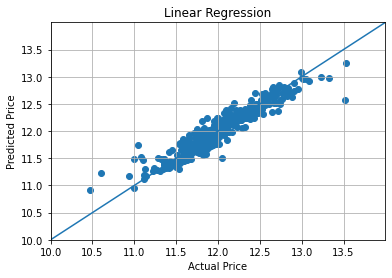

In [10]:
X = train.copy()
Y = train_sale_price.copy()

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=.33)
actual_log_prices = y_test

lr = linear_model.LinearRegression()
model = lr.fit(x_train, y_train)
predicted_log_prices = model.predict(x_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

print(np.sqrt(mean_squared_error(predicted_log_prices, actual_log_prices)))

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(10, 14, .5))
ax.set_yticks(np.arange(10, 14, .5))
plt.xlim(10,  14)
plt.ylim(10, 14)
plt.plot([10,14], [10,14])
plt.grid()
plt.scatter(actual_log_prices, predicted_log_prices)
plt.ylabel('Predicted Price')
plt.xlabel('Actual Price')
plt.title('Linear Regression')
plt.show() 

Next the linear regression using the whole of X and Y, with this reduced set of features.

In [12]:
model = lr.fit(X, Y)
X_test = test.copy()
predicted_log_prices = model.predict(X_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

submission['SalePrice'] = predicted_log_prices['SalePrice'].apply(np.exp)
submission.to_csv('submission.csv',index=False)

Submitting to kaggle gives a **RMSE score of 0.14157**, worse than that obtained in step 3 when we removed correlations between -0.05 and +0.05.

Next the train-test split linear regression with the 43 numerical features, ignoring the one-hot encoded categorical features.

0.15634923737386677


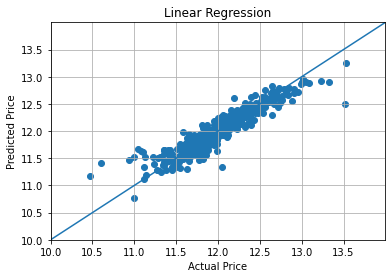

In [13]:
X = X[numeric_features_columns] # We restrict to the numeric features
x_train = x_train[numeric_features_columns] # We restrict to the numeric features
x_test = x_test[numeric_features_columns] # We restrict to the numeric features
# Y and y_train and y_test are are unchanged from above

lr = linear_model.LinearRegression()
model = lr.fit(x_train, y_train)
predicted_log_prices = model.predict(x_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

print(np.sqrt(mean_squared_error(predicted_log_prices, actual_log_prices)))

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(10, 14, .5))
ax.set_yticks(np.arange(10, 14, .5))
plt.xlim(10,  14)
plt.ylim(10, 14)
plt.plot([10,14], [10,14])
plt.grid()
plt.scatter(actual_log_prices, predicted_log_prices)
plt.ylabel('Predicted Price')
plt.xlabel('Actual Price')
plt.title('Linear Regression')
plt.show() 

Finally the linear regression using the whole of X and Y, using only the 46 numerical features.

In [14]:
model = lr.fit(X, Y)
X_test = X_test[numeric_features_columns] # We restrict to the numeric features
predicted_log_prices = model.predict(X_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

submission['SalePrice'] = predicted_log_prices['SalePrice'].apply(np.exp)
submission.to_csv('submission.csv',index=False)

Submitting to kaggle gives a **RMSE score of 0.14997**, worse than that obtained in step 4.